# Variational Autoencoders for Collaborative Filtering on MovieLens dataset.






# Imports

In [ ]:
!sudo apt install gcc

In [ ]:
%pip insatall recommenders
%pip insatall papermill

In [ ]:
import sys
import os
import numpy as np
import pandas as pd
import papermill as pm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

In [ ]:
from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.datasets.split_utils import min_rating_filter_pandas
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.datasets.sparse import AffinityMatrix
from recommenders.utils.python_utils import binarize
from recommenders.models.vae.standard_vae import StandardVAE

In [ ]:
TOP_K = 100

MOVIELENS_DATA_SIZE = '1m'

HELDOUT_USERS = 600
INTERMEDIATE_DIM = 200
LATENT_DIM = 70
EPOCHS = 400
BATCH_SIZE = 100

SEED = 98765

# 3 Data Preparation

### 3.1 Load data and split



#### Load data

In [ ]:
df = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=["userID", "itemID", "rating", "timestamp"]
)

df.head()

100%|██████████| 5.78k/5.78k [00:00<00:00, 6.25kKB/s]


,userID,itemID,rating,timestamp
0,1,1193,5.0,978300760
1,1,661,3.0,978302109
2,1,914,3.0,978301968
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291


In [ ]:
df.shape

(1000209, 4)

#### Data Filtering



Makeing sure that user-to-movie interactions with rating <=3.5 are filtered out.



In [ ]:
df_preferred = df[df['rating'] > 3.5]
print(df_preferred.shape)
df_low_rating = df[df['rating'] <= 3.5]

df_preferred.head(10)

(575281, 4)


,userID,itemID,rating,timestamp
0,1,1193,5.0,978300760
3,1,3408,4.0,978300275
4,1,2355,5.0,978824291
6,1,1287,5.0,978302039
7,1,2804,5.0,978300719
8,1,594,4.0,978302268
9,1,919,4.0,978301368
10,1,595,5.0,978824268
11,1,938,4.0,978301752
12,1,2398,4.0,978302281


In [ ]:
df_low_rating

,userID,itemID,rating,timestamp
1,1,661,3.0,978302109
2,1,914,3.0,978301968
5,1,1197,3.0,978302268
16,1,2687,3.0,978824268
20,1,2321,3.0,978302205
...,...,...,...,...
1000195,6040,1079,2.0,956715648
1000197,6040,2020,3.0,956715288
1000198,6040,2021,3.0,956716374
1000203,6040,1090,3.0,956715518


Makeing sure that the users who clicked less than 5 movies are filtered out.


In [ ]:
df = min_rating_filter_pandas(df_preferred, min_rating=5, filter_by="user")

df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")

#### Split data
Data stlit by users is 10% validation set, 10% testing set  and 80% training set.
Validation and test set should not contain movies that do not exist in the train set.

In [ ]:
unique_users = sorted(df.userID.unique())
unique_users = np.random.permutation(unique_users)

In [ ]:
n_users = len(unique_users)
train_users = unique_users[:(n_users - HELDOUT_USERS * 2)]
val_users = unique_users[(n_users - HELDOUT_USERS * 2) : (n_users - HELDOUT_USERS)]
test_users = unique_users[(n_users - HELDOUT_USERS):]

print("Number of unique users:", n_users)
print("Number of training users:", len(train_users))
print("Number of validation users:", len(val_users))
print("Number of test users:", len(test_users))

Number of unique users: 6034

Number of training users: 4834

Number of validation users: 600

Number of test users: 600


In [ ]:
train_set = df.loc[df['userID'].isin(train_users)]
val_set = df.loc[df['userID'].isin(val_users)]
test_set = df.loc[df['userID'].isin(test_users)]

In [ ]:
unique_train_items = pd.unique(train_set['itemID'])

In [ ]:
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]

## 3.2 Click matrix generation

Building click matrix 4 datasets with split of 75% on 25%:
- val_data_tr
- val_data_te
- test_data_tr
- test_data_te


In [ ]:
am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)
am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)
am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)

In [ ]:
train_data, _, _ = am_train.gen_affinity_matrix()
val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()


print(test_data.shape)
print(train_data.shape)
print(val_data.shape)

(4834, 3497)
(600, 3497)
(600, 3497)


In [ ]:
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75)

In [ ]:
train_data = binarize(a=train_data, threshold=3.5)
val_data = binarize(a=val_data, threshold=3.5)
test_data = binarize(a=test_data, threshold=3.5)

In [ ]:
val_data_tr = binarize(a=val_data_tr, threshold=3.5)
val_data_te_ratings = val_data_te.copy()
val_data_te = binarize(a=val_data_te, threshold=3.5)

In [ ]:
test_data_tr = binarize(a=test_data_tr, threshold=3.5)
test_data_te_ratings = test_data_te.copy()
test_data_te = binarize(a=test_data_te, threshold=3.5)

In [ ]:
test_data_te_ratings=pd.DataFrame(test_data_te_ratings)
val_data_te_ratings=pd.DataFrame(val_data_te_ratings)

for index,i in df_low_rating.iterrows():
  user_old= i['userID']
  item_old=i['itemID']

  if (test_map_users.get(user_old) is not None)  and (test_map_items.get(item_old) is not None) :
      user_new=test_map_users.get(user_old)
      item_new=test_map_items.get(item_old)
      rating=i['rating']
      test_data_te_ratings.at[user_new,item_new]= rating

  if (val_map_users.get(user_old) is not None)  and (val_map_items.get(item_old) is not None) :
      user_new=val_map_users.get(user_old)
      item_new=val_map_items.get(item_old)
      rating=i['rating']
      val_data_te_ratings.at[user_new,item_new]= rating


val_data_te_ratings=val_data_te_ratings.to_numpy()
test_data_te_ratings=test_data_te_ratings.to_numpy()

## 4 Build VAE with $\mathbf \beta$= 1.

In [ ]:
model_without_anneal = StandardVAE(n_users=train_data.shape[0],
                                   original_dim=train_data.shape[1],
                                   intermediate_dim=INTERMEDIATE_DIM,
                                   latent_dim=LATENT_DIM,
                                   n_epochs=EPOCHS,
                                   batch_size=BATCH_SIZE,
                                   k=TOP_K,
                                   verbose=0,
                                   drop_encoder=0.5,
                                   drop_decoder=0.5,
                                   annealing=False,
                                   beta=1.0
                                   )

In [ ]:
model_without_anneal.fit(
    x_train=train_data,
    x_valid=val_data,
    x_val_tr=val_data_tr,
    x_val_te=val_data_te_ratings,
    mapper=am_val
    )

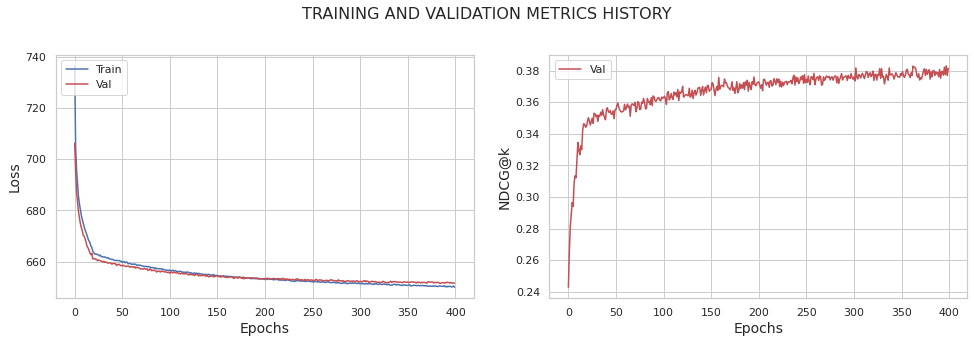

In [ ]:
model_without_anneal.display_metrics()

In [ ]:
ndcg_val_without_anneal = model_without_anneal.ndcg_per_epoch()

#### Prediction and Evaluation of VAE model with $\beta$ = 1.

Evaluate with k = 10

In [ ]:
top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                k=10,
                                                remove_seen=True
                                                )

top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings')


# ranking metrics
eval_map_1 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_1 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_1 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_1 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print(f"MAP@10:\t\t {eval_map_1}")
print(f"NDCG@10:\t{eval_ndcg_1}")
print(f"Precision@10:\t{eval_precision_1}")
print(f"Recall@10: \t{eval_recall_1}")

MAP@10:		 0.041101
NDCG@10:	0.406207
Precision@10:	0.321167
Recall@10: 	0.091352


Evaluate with k = 100

In [ ]:
top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                k=TOP_K,
                                                remove_seen=True
                                                )

top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings')

# ranking metrics
eval_map_2 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_ndcg_2 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_precision_2 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_recall_2 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)

print(f"MAP@10:\t\t {eval_map_1}")
print(f"NDCG@10:\t{eval_ndcg_1}")
print(f"Precision@10:\t{eval_precision_1}")
print(f"Recall@10: \t{eval_recall_1}")

MAP@10:		 0.128121
NDCG@10:	0.312319
Precision@10:	0.191383
Recall@10: 	0.224346


# 5 Conclusion

In conclusion, we observe that our model exhibits slightly less impressive results than the one presented in the paper. This discrepancy can be attributed to differences in dataset size (1 million in our case versus 20 million in the paper) and variations in model parameters.